In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras.layers import Dense

tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)

In [2]:
# всякие константы для последующей работы

#///////////////////////////////// для взятия данных из файлов

path_to_data = ('ngp.csv','timesereis_8_2.csv')
target = 'price'

#///////////////////////////////// для создания слоев

hidden_layer_act_fun = 'relu'   # функция активация скрытых слоев и входного
output_layer_act_fun = 'sigmoid' #'linear' # функция активация выходного слоя

cur_dict = {8: hidden_layer_act_fun, 
            400: hidden_layer_act_fun, #400 20
            20: hidden_layer_act_fun,
            2: output_layer_act_fun} # size(layer) plus activation func
    
            #4: hidden_layer_act_fun, #5: hidden_layer_act_fun, 
            #900: hidden_layer_act_fun, #400: hidden_layer_act_fun, 
            #7: hidden_layer_act_fun, #50: hidden_layer_act_fun, 
            #1: output_layer_act_fun}

#///////////////////////////////// для компиляции 

learning_rate = 0.00005 # шаг сходимости back propogation
cur_solver = keras.optimizers.Adam(learning_rate) # # оптимизатор
loss_func = 'mean_squared_error'# функция потерь

#///////////////////////////////// для колбэков

    # для Early_stopping
cur_patience = 15 # кол-во эпох без улучшений
cur_min_delta = 0.0001 # минимальное улучшение параметра за cur_patience
cur_monitor_parametr_in_early_stopping =  'loss' # отслеживаемый параметр 
cur_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами

#///////////////////////////////// для тренировки

cur_batch_size = 4 #13, 4 # размер bach при обучении/тестировании
cur_shuffle = True # перемешивать ли данные
cur_verbose = True # выводить ли прогресс обучения в его процессее
cur_epochs = 50 # количество эпох обучения
cur_validation_split = 0.2 # процент валидационных данных, отсекаемых из тестовой выборки

In [3]:
def get_df(path, target_name):
    print("///////// get_df /////////")
    file = pd.read_csv(path)
    dframe = pd.DataFrame(list(reversed(file[target_name])))
    #print(dframe)
    print("///////// get_df_end /////////")
    return dframe

In [4]:
def get_cols_and_names(df):
    input_t = 4
    output_t = 1
    
    cols = list()
    names = list()
    
    print("///////// get_cols_and_names /////////")
    for i in range(input_t,0, -1):
        cols.append(df.shift(i))
        #print(f"df.shift({i}).shape: ", df.shift(i).shape, "type: ", type(df.shift(i)))
        names.append(i)
    print("///////// Next loop /////////")
    for i in range(0,output_t):
        cols.append(df.shift(-i))                    
        #print(f"df.shift({-i}).shape: ", df.shift(-i).shape, "type: ", type(df.shift(-i)))
        names.append(i+input_t+1)
    
    print("///////// get_cols_and_names_end /////////")
    return cols,names

In [5]:
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [6]:
def prepare_df(cols,names):
    print("///////// prepare_df /////////")
    n_df = pd.concat(cols, axis = 1)
    n_df.columns = names
    
    #print("n_df: ", n_df)
    
    n_df.dropna(inplace = True)
    
    #print("n_df: ", n_df)
    
    print("///////// prepare_df_end /////////")
    return n_df

In [7]:
# данные из 2 файла
def prep_data_8_2_time(path):
    file = pd.read_csv(path)
    
    X = file[['0','1','2','3','4','5','6','7']]
    X = X / X.max()
    Y = file[['8','9']]
    Y = Y / Y.max()

    #ones = np.ones(shape = (X.shape[0], 1)) добавление столбца единиц
    #X = np.append(X, ones, axis=1)
    
    Y = np.asarray(Y)
    factor=int(.80 * X.shape[0])

    return split(X, Y, factor)

In [8]:
#from IPython.display import display
def prep_data_4_1_time(cols, names, prepared_df):
    print("///////// prep_data_4_1_time /////////")
 
    X = prepared_df[[4, 3, 2, 1]]
    Y = prepared_df[5]
    X = X / X.max()
    
    
    ############# добавление столбца единиц
    #ones = np.ones(shape = (X.shape[0], 1))
    #X = np.append(X, ones, axis = 1)
    #############
    
    Y = np.asarray(Y)
    Y = Y / Y.max()
    
    #print("X[0], Y[0]", X[0], Y[0])
    #print("X[1], Y[1]", X[1], Y[1])
    
    #print("X: ", X)
    #print("Y: ", Y)
    
    factor = int(.80*X.shape[0])

    print("///////// prep_data_4_1_time_end /////////")
    return split(X ,Y , factor)

In [9]:
# создание архитектуры нейронки
model = keras.Sequential()

for x in cur_dict.items():
    model.add(Dense(x[0], activation = x[1]))
    
model.compile(loss = loss_func, optimizer = cur_solver)

In [10]:
# Создание и настройка колбэков
callback_arr = []
temp = keras.callbacks.EarlyStopping(
            monitor = cur_monitor_parametr_in_early_stopping, 
            min_delta = cur_min_delta, 
            patience = cur_patience,
            restore_best_weights = cur_save_best_weights
            )
callback_arr.append(temp)

#temp = keras.callbacks.ProgbarLogger(
#            count_mode='samples', 
#            stateful_metrics = ['loss','val_loss','accuracy']
#            )
#callback_arr.append(temp)

#cur_callback = keras.callbacks.CallbackList(
#    callbacks = callback_arr, add_history = True, add_progbar = False, model = model)


In [11]:
# подготовка данных

'''# извлечь датасет из файла
df = get_df(path_to_data[0], target)
# заполнить колонки и имена колонок для тестового датасета
cols, names = get_cols_and_names(df)
# создать тестовый/тренировочный датасет
prepared_df = prepare_df(cols,names)
# создать тестовые/тренировочные данные из тестового датасета
prepared_data = prep_data_4_1_time(cols, names, prepared_df)'''

prepared_data = prep_data_8_2_time(path_to_data[1])

X_train,Y_train,X_test,Y_test = prepared_data

In [12]:
# тренировка модели
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = cur_batch_size, 
                    epochs = cur_epochs, 
                    verbose = cur_verbose, 
                    validation_split = cur_validation_split, 
                    shuffle = cur_shuffle, 
                    callbacks = callback_arr)

Epoch 1/50

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

171/171 [==============================] - 0s 2ms/step - loss: 0.0508 - val_loss: 0.0518
Epoch 2/50
171/171 [==============================] - 0s 1ms/step - loss: 0.0463 - val_loss: 0.0433
Epoch 3/50
171/171 [==============================] - 0s 1ms/step - loss: 0.0430 - val_loss: 0.0376
Epoch 4/50
171/171 [==============================] - 0s 1ms/step - loss: 0.0397 - val_loss: 0.0334
Epoch 5/50
171/171 [==============================] - 0s 999us/step - loss: 0.0361 - val_loss: 0.0304
Epoch 

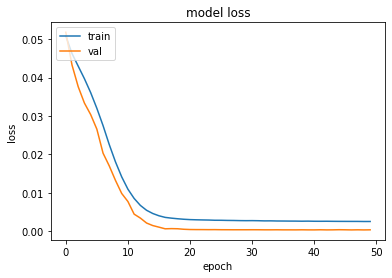

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [14]:
# тест модели

model.evaluate(X_test, Y_test, batch_size = cur_batch_size)

54/54 [==============================] - 0s 1ms/step - loss: 5.6661e-04


0.0005666132783517241

In [15]:
#MLPRegressor?
#keras.Sequential?
#keras.Sequential.fit?
#keras.callbacks.Callback()
#keras.Sequential.compile?